In [ ]:
#| default_exp data

# Data functionalities

> Generating and importing data

In [ ]:
#| export
from types import SimpleNamespace
from torchvision.datasets import MNIST

In [ ]:
PATH = "."

In [ ]:
mnist = MNIST(PATH, download=True)
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

In [ ]:
mnist.data.shape

torch.Size([60000, 28, 28])

## Visualizing the dataset

In [ ]:
from torch_moving_mnist.utils import show_image, show_images

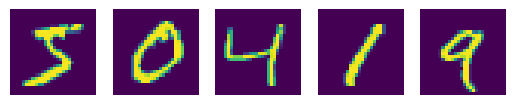

In [ ]:
show_images(mnist.data[0:5]);

## Generating moving mnist sequences:

In [ ]:
#| export
import random
from typing import List, Dict, Tuple

import torch
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

mnist_stats    = ([0.131], [0.308])

We can leverage torchvision's affine transform!

In [ ]:
digit = torch.tensor(mnist.data[[0]])

<AxesSubplot: >

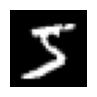

In [ ]:
show_image(digit)

In [ ]:
angle = 20  # rotation in degrees
scale = 1.3 # scaling in percentage (1.0 = no scaling)
translate = (2,3) # translation in pixels
shear = 15 # deformation on the z-plane

<AxesSubplot: >

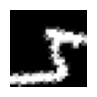

In [ ]:
show_image(TF.affine(digit, angle, translate, scale, shear))

we should probably pad first, so we don't get out of the canvas

In [ ]:
#| export
def padding(img_size=128, mnist_size=28): return (img_size - mnist_size) // 2

In [ ]:
padding(64)

18

<AxesSubplot: >

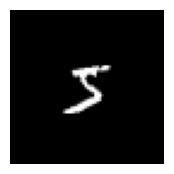

In [ ]:
pdigit = TF.pad(digit, padding=18)  #18 give us a 64x64 image (18x2 + 28)
show_image(pdigit)

<AxesSubplot: >

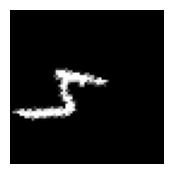

In [ ]:
show_image(TF.affine(pdigit, angle, (-10,3), scale, shear))

In [ ]:
#| export
def linear_schedule(a:float, b:float, n:int=5):
    "equivalent to np.linspace"
    return [i*(b-a)/(n-1) + a for i in range(n)]

In [ ]:
linear_schedule(1,20)

[1.0, 5.75, 10.5, 15.25, 20.0]

In [ ]:
angles = linear_schedule(-10,20)
angles

[-10.0, -2.5, 5.0, 12.5, 20.0]

In [ ]:
#| export
affine_params = SimpleNamespace(
    angle=(-20, 20),
    translate=((-30, 30), (-30, 30)),
    scale=(.8, 1.3),
    shear=(-20, 20),
)

In [ ]:
#| export
def random_linear_schedule(a:float, b:float, n:int=5):
    x = random.uniform(a,b)
    y = random.uniform(a,b)
    return linear_schedule(x, y, n=n)

In [ ]:
random_linear_schedule(-10, 2)

[-6.961375626970929,
 -7.183530278710095,
 -7.405684930449262,
 -7.627839582188428,
 -7.849994233927594]

In [ ]:
random_linear_schedule(.8, 1.3)

[0.8247449050840815,
 0.8585580717120365,
 0.8923712383399913,
 0.9261844049679463,
 0.9599975715959013]

In [ ]:
#| export
class Trajectory:
    def __init__(self, 
                 angle: Tuple[float, float], 
                 translate: Tuple[Tuple[float, float], Tuple[float,float]], 
                 scale: Tuple[float, float], 
                 shear: Tuple[float, float], 
                 n: int=5):
        self.angle_schedule = random_linear_schedule(*angle, n=n)
        self.scale_schedule = random_linear_schedule(*scale, n=n)
        translate_x = random_linear_schedule(*translate[0], n=n)
        translate_y = random_linear_schedule(*translate[1], n=n)
        self.translate_schedule = list(zip(translate_x, translate_y))
        self.shear_schedule = random_linear_schedule(*shear, n=n)
        
    def points(self):
        return list(zip(self.angle_schedule , self.translate_schedule, self.scale_schedule, self.shear_schedule))
            
    def apply(self, img):
        return [TF.affine(img, *param) for param in self.points()]

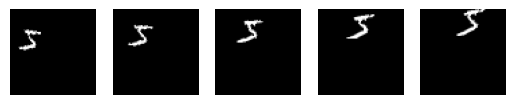

In [ ]:
t = Trajectory(**vars(affine_params))
show_images([TF.affine(pdigit, *param) for param in t.points()])

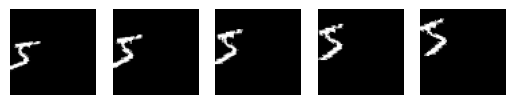

In [ ]:
params = Trajectory(**vars(affine_params))
show_images(params.apply(pdigit))

In [ ]:
#| export
import math
import random

class MovingMNIST:
    def __init__(self, path=".",  # path to store the MNIST dataset
                 affine_params: Dict=affine_params, # affine transform parameters, refer to torchvision.transforms.functional.affine
                 num_digits: List[int]=[3], # how many digits to move, random choice between the value provided
                 num_frames: int=4, # how many frames to create
                 img_size:int=64, # the canvas size, the actual digits are always 28x28
                 concat:bool=True, # if we concat the final results (frames, 1, 28, 28) or a list of frames.
                 normalize:bool=True # scale images in [0,1] and normalize them with MNIST stats. Applied at batch level. Have to take care of the canvas size that messes up the stats!
                ):
        self.mnist = MNIST(path, download=True).data
        self.affine_params = affine_params
        self.num_digits = num_digits
        self.num_frames = num_frames
        self.img_size = img_size
        self.pad = padding(img_size)
        self.concat = concat
        
        # some computation to ensure normalizing correctly-ish
        batch_tfms = [T.ConvertImageDtype(torch.float32)]
        if normalize:
            ratio = (28/img_size)**2*max(num_digits)
            mean, std = mnist_stats
            scaled_mnist_stats = ([mean[0]*ratio], [std[0]*ratio])
            print(f"New computed stats for MovingMNIST: {scaled_mnist_stats}")
            batch_tfms += [T.Normalize(*scaled_mnist_stats)] if normalize else []
        self.batch_tfms = T.Compose(batch_tfms)  
    
    def random_digit(self):
        img = self.mnist[[random.randrange(0, len(self.mnist))]]
        return TF.pad(img, padding=self.pad) 
    
    def random_trajectory(self):
        return Trajectory(**self.affine_params, n=self.num_frames)
    
    def _one_moving_digit(self):
        digit = self.random_digit()
        traj = self.random_trajectory()
        return torch.stack(traj.apply(digit))
    
    def __getitem__(self, i):
        moving_digits = [self._one_moving_digit() for _ in range(random.choice(self.num_digits))]
        moving_digits = torch.stack(moving_digits)
        combined_digits = moving_digits.max(dim=0)[0]
        return combined_digits if self.concat else [t.squeeze(dim=0) for t in combined_digits.split(1)]
    
    def get_batch(self, bs=32):
        "Grab a batch of data"
        batch = torch.stack([self[0] for _ in range(bs)])
        return self.batch_tfms(batch) if self.batch_tfms is not None else batch

This is an random MNIST Dataset:

In [ ]:
mnist[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [ ]:
vars(affine_params)

{'angle': (-20, 20),
 'translate': ((-30, 30), (-30, 30)),
 'scale': (0.8, 1.3),
 'shear': (-20, 20)}

In [ ]:
ds = MovingMNIST(affine_params=vars(affine_params))

New computed stats for MovingMNIST: ([0.07522265625], [0.17685937499999999])


torch.Size([4, 1, 64, 64])


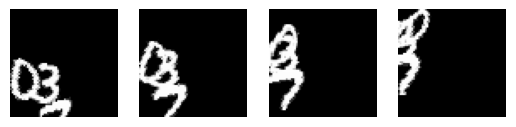

In [ ]:
digits = ds[0]
print(digits.shape)
show_images(digits)

In [ ]:
b = ds.get_batch(bs=32)
b.shape

torch.Size([32, 4, 1, 64, 64])

without concat

In [ ]:
ds.concat=False

In [ ]:
type(ds[0]), ds[0][0].shape

(list, torch.Size([1, 64, 64]))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()